In [47]:
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2
from qiskit.circuit import ClassicalRegister

from azure.quantum import Workspace 
from azure.quantum.qiskit import AzureQuantumProvider
import sys
import os

sys.path.append(os.path.abspath("..\\..\\..\\.."))
from objects.shor_code_circuit import ShorCodeCircuit
from functions import *

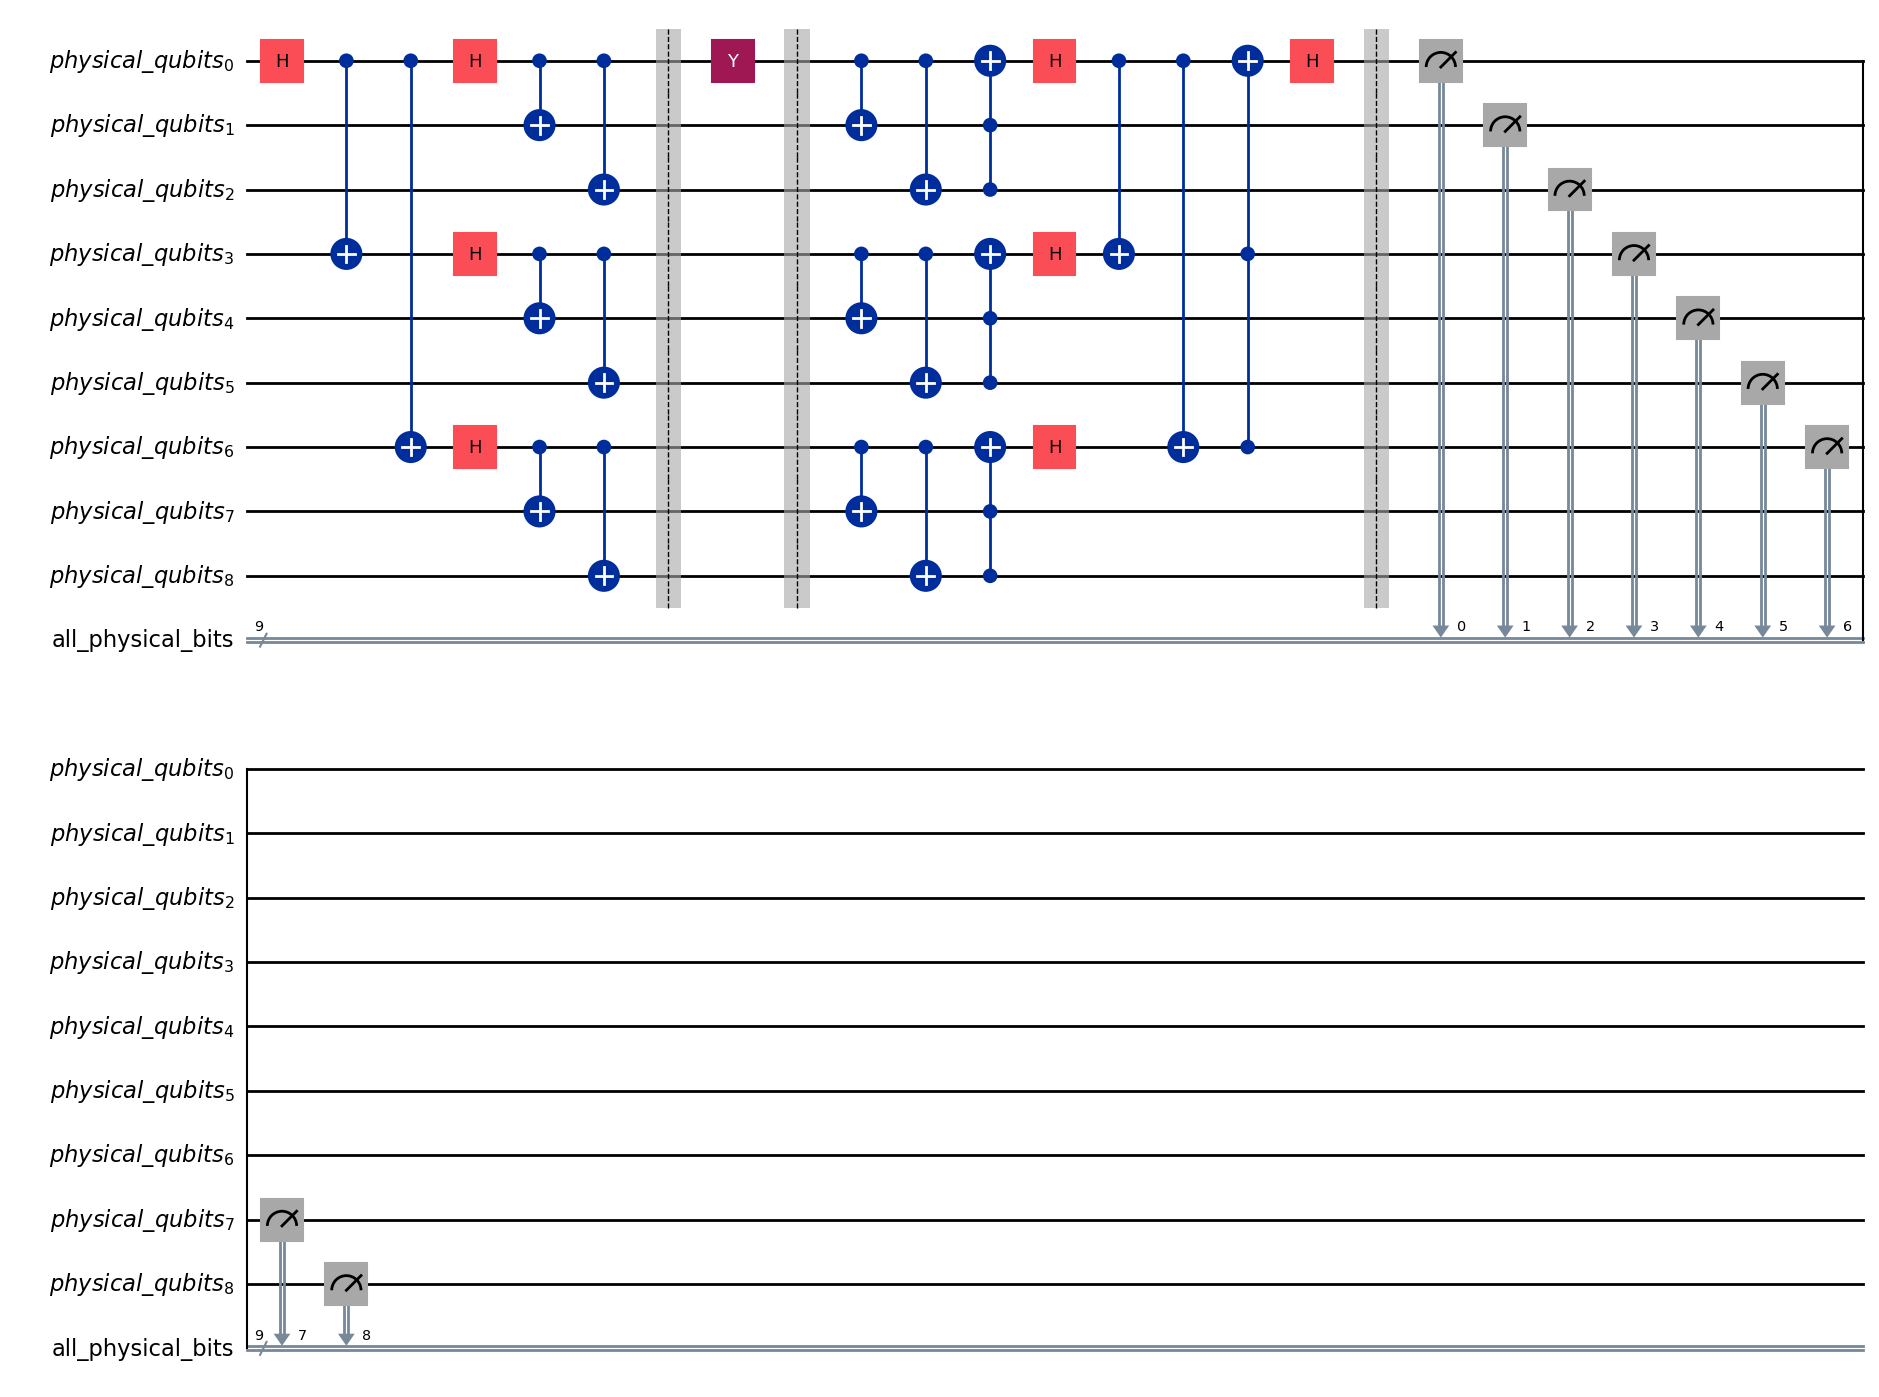

In [49]:
def load_circuit(initial_state='0', error = (None, None), measure='decoded_state', decoding=True, encoding='universal'):
    
    qc = ShorCodeCircuit(1)

    if initial_state == '1':
        qc.physical_quantum_circuit.x(0)
    elif initial_state == '+':
        qc.physical_quantum_circuit.h(0)
    elif initial_state == '-':
        qc.physical_quantum_circuit.x(0)
        qc.physical_quantum_circuit.h(0)
    else:
        pass

    if encoding == 'universal':
        qc.encode()
    elif encoding == 'particular':
        qc.encode(initial_state='0')

    qc.barrier()

    if error:
        position = error[1]
        match error[0]:
            case 'X':
                qc.physical_quantum_circuit.x(position)
            case 'Y':
                qc.physical_quantum_circuit.y(position)
            case 'Z':
                qc.physical_quantum_circuit.z(position)

    qc.barrier()

    if decoding:
        qc.decode()

        if initial_state in ['+', '-']:
            qc.physical_quantum_circuit.h(0)

        qc.barrier()

    match measure:
        case 'decoded_state':
            circuit = qc.physical_quantum_circuit
            creg = ClassicalRegister(1, 'c')
            circuit.add_register(creg)
            circuit.measure(circuit.qubits[0], creg)
        case 'all':
            qc.measure_all(basis='all')

    return qc


qc = load_circuit(initial_state='+', error=('Y',0),
                   measure='all',
                   )
qc.draw_physical_circuit('mpl')

In [50]:
# IonQ access
workspace = Workspace(  
    resource_id = "", # Add the resourceID of your workspace
    location = "" # Add the location of your workspace (for example "westus")
    )

provider = AzureQuantumProvider(workspace)

In [51]:
backend_name = "ionq.qpu.aria-1"
backend_name_simulator = "ionq.simulator"
backend = provider.get_backend(backend_name)
simulator_backend = provider.get_backend(backend_name_simulator)

option_params = {
    "error-mitigation": {
        "debias": False,
        "sharpen": False
    }
}

backend.options.update_options(**option_params)
simulator_backend.options.update_options(**option_params)
simulator_backend.options.update_options(noise_model="aria-1") 

Transpiled Circuit Depth: 16


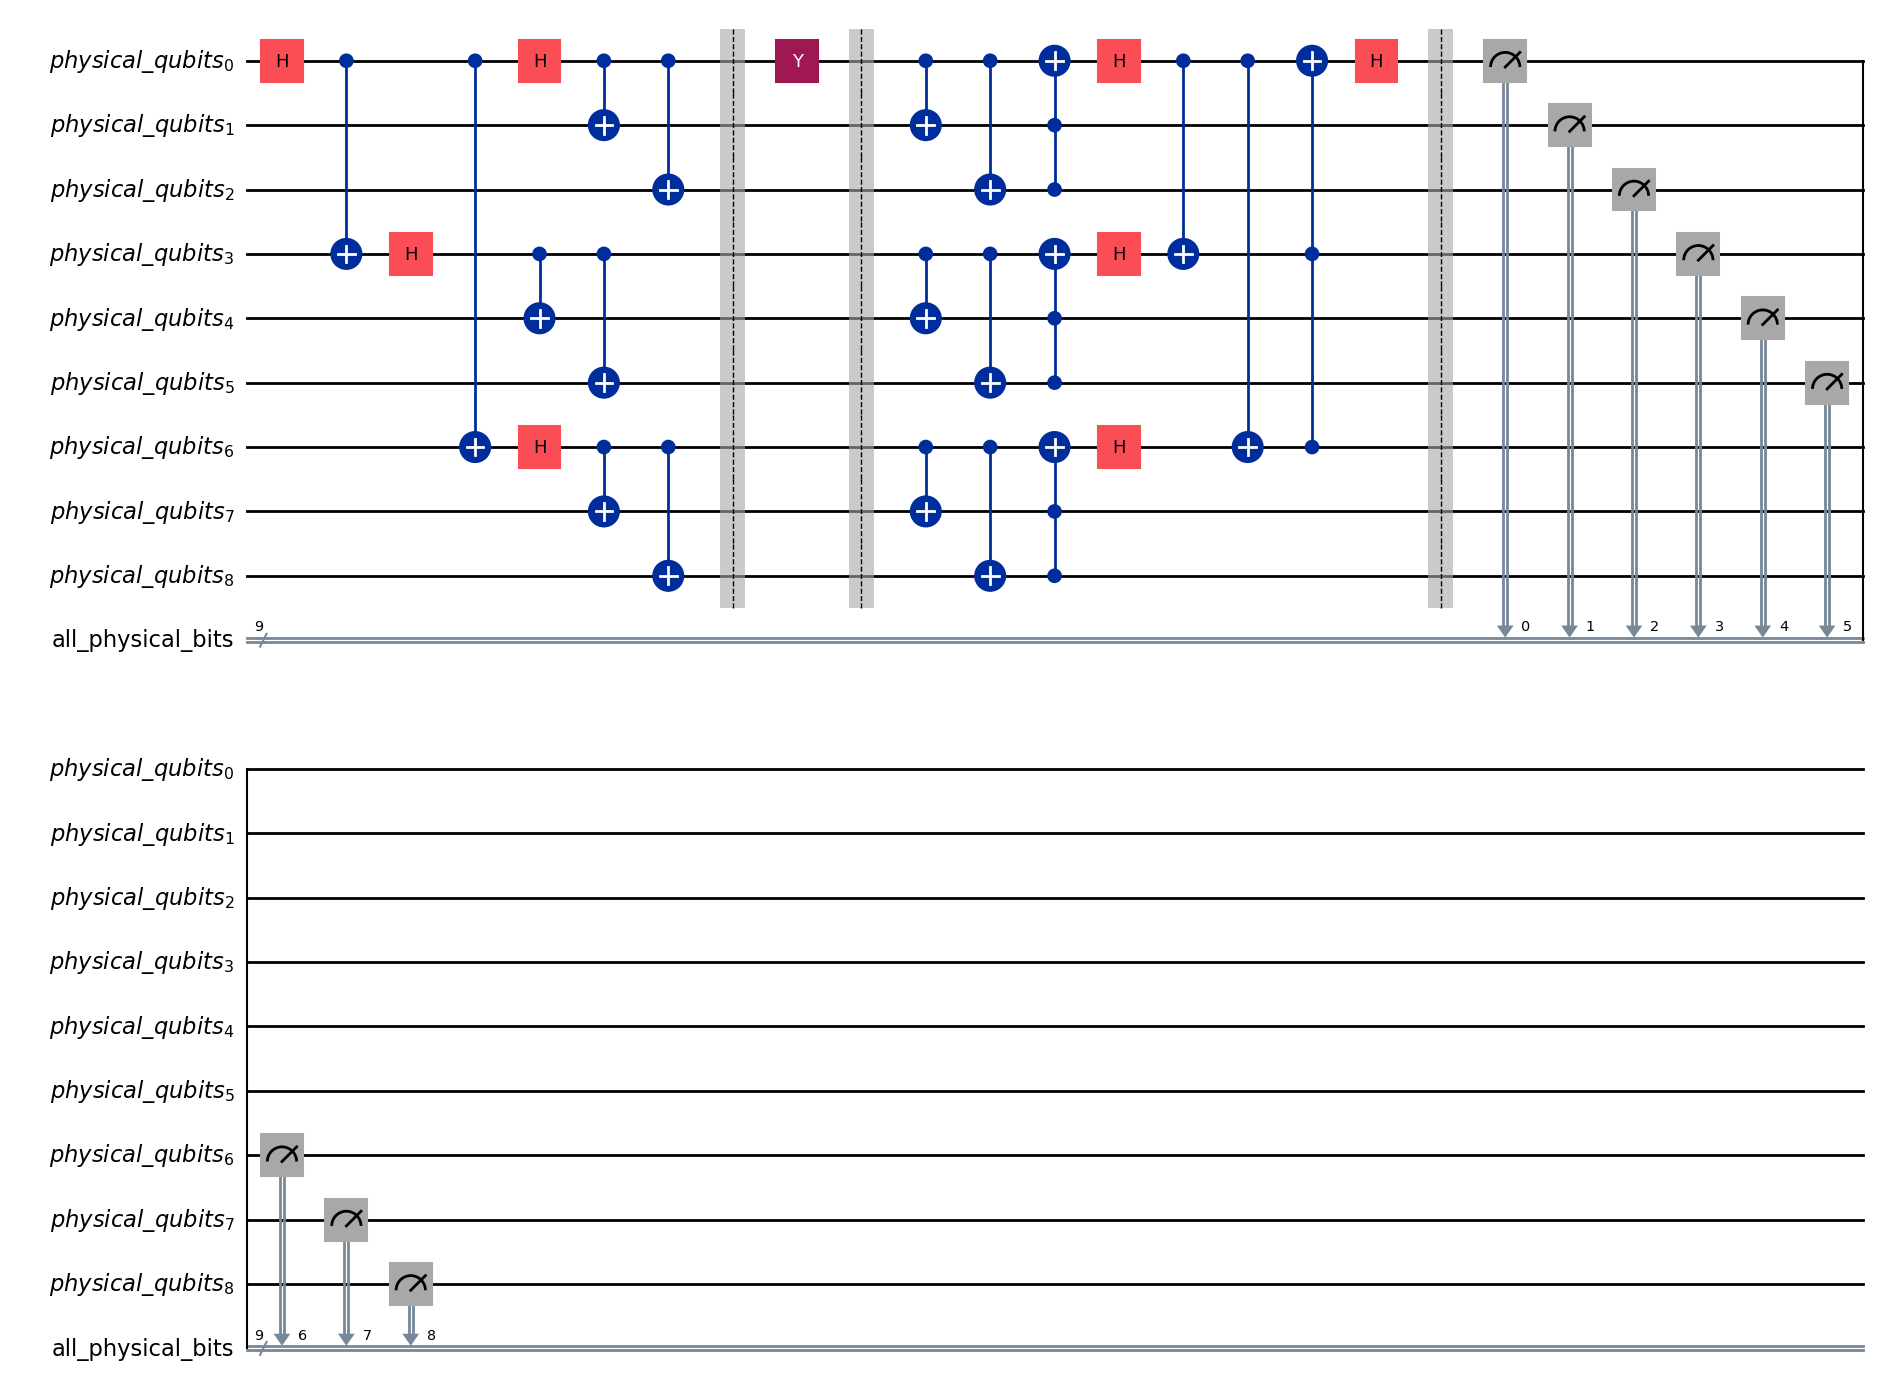

In [54]:
phy_qc = qc.physical_quantum_circuit
isa_circuit = transpile(phy_qc, backend)
print(f"Transpiled Circuit Depth: {isa_circuit.depth()}")
isa_circuit.draw('mpl')

In [55]:
shots = 2000

simulation_result = sampler_simulation(qc.physical_quantum_circuit, shots)

extract_simulation_results(simulation_result, omit_zeros=True)

{'all_physical_bits': [{'011100100': 2000}]}

Run experiment

In [ ]:
# job = backend.run(isa_circuit, shots=shots)

# job_id = job.id()
# print(f"Job ID: {job_id}")

Job ID: 37a72546-fc79-11ef-95de-3800255d459d


Jobs:
- 17ac2946-fbad-11ef-9dc3-3800255d459d, 'shor_enc&error&dec1_Y0.json': $\ket{1}_L$ encoder universal, 2000 shots, error Y0
- dc46681a-fc6b-11ef-bcf4-3800255d459d, 'shor_enc&error&dec0_Y0.json': $\ket{0}_L$ encoder particular, 2000 shots, error Y0
- 37a72546-fc79-11ef-95de-3800255d459d, 'shor_enc&error&dec+_Y0.json': $\ket{+}_L$ encoder universal, 2000 shots, error Y0


In [74]:
json_files = []
for state in ['0', '1', '+']:
    for error in ['Y0']:
        json_files.append(f"shor_enc&error&dec{state}_{error}.json")

        try:
            results = extract_results_json_IONQ(json_files[-1], type='percentage')[0]
        except:
            continue
        
        print(f"state {state}, error {error}")

        final_state = '1' if state == '1' else '0'
        
        st_syn_results = {
        (st, syn) : round(sum([
                results[state]
                for state in results
                if (state[1:] == '11100100') == syn
                and (state[:1] == final_state) == st
            ]), 2)
            for st in [True, False] for syn in [True, False]
        }

        print(f"dec state | syndrome | counts (%)")
        print(*st_syn_results.items(), sep='\n')
        print('Correction accuracy:', round(sum([st_syn_results[k] for k in st_syn_results if k[0]]),2), '%')
        print('\n')

state 0, error Y0
dec state | syndrome | counts (%)
((True, True), 93.55)
((True, False), 5.1)
((False, True), 0.9)
((False, False), 0.45)
Correction accuracy: 98.65 %


state 1, error Y0
dec state | syndrome | counts (%)
((True, True), 91.55)
((True, False), 5.35)
((False, True), 1.7)
((False, False), 1.4)
Correction accuracy: 96.9 %


state +, error Y0
dec state | syndrome | counts (%)
((True, True), 95.05)
((True, False), 4.3)
((False, True), 0.65)
((False, False), 0.0)
Correction accuracy: 99.35 %




Analysis

In [84]:
results = extract_results_json_IONQ('shor_enc&error&dec+_Y0.json', type='percentage', reverse_order=True)[0]

In [85]:
states = get_possible_states(9)
valid_states = ['011100100']

# plot_results_hamming_distance(results, 9, valid_states, omit_zeros=True)

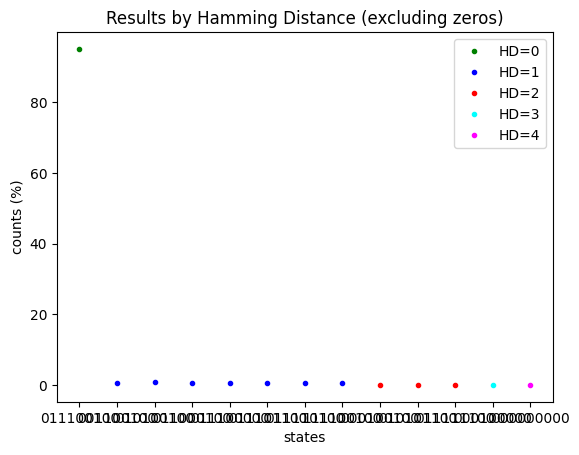

In [86]:
plot_results_hamming_distance(results, 9, valid_states, omit_zeros=True)

In [87]:
print_order_results(results, valid_states, limit=10)

state: result, HD, error positions
011100100: 95.05%, 0, [[]]
010100100: 0.85%, 1, [[2]]
011000100: 0.7%, 1, [[3]]
011101100: 0.7%, 1, [[5]]
011110100: 0.7%, 1, [[4]]
111100100: 0.65%, 1, [[0]]
001100100: 0.6%, 1, [[1]]
011100000: 0.5%, 1, [[6]]
000000000: 0.05%, 4, [[1, 2, 3, 6]]
000100000: 0.05%, 3, [[1, 2, 6]]


Final Decoded State

In [93]:
similarity = sum([
    results[state]
    for state in results
    if state[0] == '0'
])
print('Similarity:', similarity,'%')

Similarity: 99.35 %


Syndromes

In [94]:
syn_states = get_possible_states(8)
syn_valid_states = [v[1:] for v in valid_states]

In [95]:
syn_results = {
    syn : sum([
        results[state]
        for state in results
        if state[1:] == syn
    ])
    for syn in syn_states
}


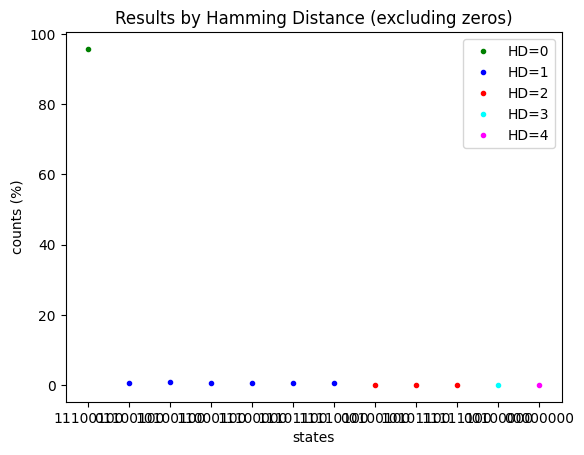

In [96]:
plot_results_hamming_distance(syn_results, 8, syn_valid_states, omit_zeros=True)

Decoded State and Syndrome all together

In [98]:
st_syn_results = {
    (st, syn) : sum([
        results[state]
        for state in results
        if (state[1:] in syn_valid_states) == syn
        and (state[:1] == '0') == st
    ])
    for st in [True, False] for syn in [True, False]
}

print(*st_syn_results.items(), sep='\n')

((True, True), 95.05)
((True, False), 4.300000000000001)
((False, True), 0.65)
((False, False), 0.0)
